# Feature Selection

Here we showcase how to use `torch_mist` for a simple feature selection procedure.
For this example, we consider the [California Housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing).
The goal is to identify which feature is the most predictive for the house value.

In [1]:
import numpy as np
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)
features = list(california_housing['data'].columns)
dataframe = california_housing['data']
target = 'Price'
targets = california_housing['target'].values.astype(np.float32).reshape(-1,1)
print(f"Features: {features}")

# Normalization function
def normalize(features):
    return {k: v/v.mean(0) for k, v in features.items()}


Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


## Estimating the maximum information content

We start by estimating how much information all the features together capture about the target price. The corresponding value sets an upper bound on any representation we can obtain by sub-selecting features.

In [2]:
from torch_mist import estimate_mi

# We create a dictionary containing the tensor of all features (x) and prices (y)
all_features = {
    'All Features': dataframe[features].values.astype(np.float32),
    'Price': targets
}
# Normalize both features and targets
all_features = normalize(all_features)

In [3]:
from torch_mist.estimators import smile

# We define a simple SMILE estimator
estimator = smile(
    x_dim=len(features),
    y_dim=1,
    hidden_dims=[256, 128, 64],
    neg_samples=8
)

# Train and evaluate the value of mutual information
all_mi_estimates, all_train_log = estimate_mi(
    estimator=estimator,
    data=all_features,
    x_key='All Features',
    y_key='Price',
    batch_size=128,
    max_epochs=50,
)


Training the estimator


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration:   0%|          | 0/146 [00:00<?, ?it/s]

Losing patience: 4
Losing patience: 3
Losing patience: 4
Losing patience: 4
Losing patience: 3
Losing patience: 2
Losing patience: 4
Losing patience: 4
Losing patience: 4
Losing patience: 3
Losing patience: 4
Losing patience: 3
Losing patience: 4
Losing patience: 3
Losing patience: 4
Losing patience: 3
Losing patience: 4
Losing patience: 4
Losing patience: 3
Losing patience: 4
Losing patience: 3
Losing patience: 2
Losing patience: 1
Evaluating the value of Mutual Information
[Warning]: using the train_data to estimate the value of mutual information. Please specify test_data.


(0.0, 0.7571627018509643)

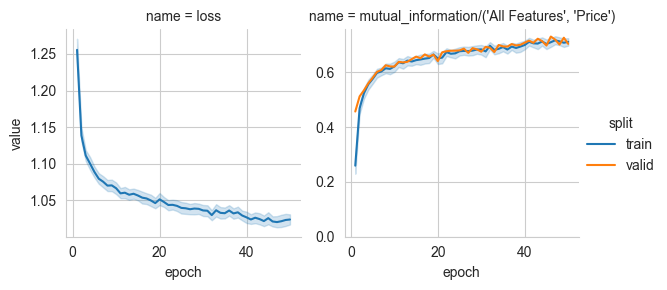

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# Plot the mutual information and loss over time
grid = sns.FacetGrid(all_train_log, hue='split', col='name', sharey=False)
grid.map(sns.lineplot, 'epoch', 'value')
grid.add_legend()
plt.ylim(0)

## Finding the most informative feature

In order to better understand the data, we consider each feature by itself and estimate how much information it captures about the house price. This procedure can help in determining the most informative component.

In [5]:
from copy import deepcopy
from torch_mist.estimators import MultiMIEstimator


# We create a dictionary containing all the features (one by one) and the price and normalize it
one_feature = {feature: california_housing['data'][feature].values.astype(np.float32) for feature in features}
one_feature[target] = california_housing['target'].values.astype(np.float32)
one_feature = normalize(one_feature)

# Starting from the same SMILE estimator
base_estimator = smile(
    x_dim=1,
    y_dim=1,
    hidden_dims=[256, 128, 64],
    neg_samples=8
)


# We create a copy for each pair of feature and target
estimators = {(feature, target): deepcopy(base_estimator) for feature in features}

# Instantiate a MultiMIEstimator to estimate all the values at once
multi_estimator = MultiMIEstimator(
    estimators
)

# And train and estimate the values of mutual information
one_mi_estimates, one_train_log = estimate_mi(
    estimator=multi_estimator,
    data=one_feature,
    batch_size=128,
    max_epochs=50,
)

Training the estimator


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration:   0%|          | 0/146 [00:00<?, ?it/s]

Losing patience: 4
Losing patience: 3
Losing patience: 2
Losing patience: 1
Losing patience: 4
Losing patience: 3
Losing patience: 2
Losing patience: 1
Losing patience: 0
No improvements on validation, stopping.
Evaluating the value of Mutual Information
[Warning]: using the train_data to estimate the value of mutual information. Please specify test_data.


(0.0, 0.3994466926498719)

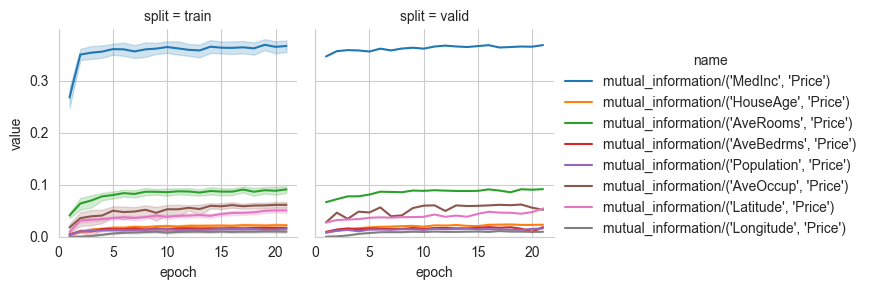

In [6]:
# Visualize the training log
grid = sns.FacetGrid(one_train_log[one_train_log['name']!='loss'], col='split', hue='name')
grid.map(sns.lineplot, 'epoch', 'value')
grid.add_legend()
plt.ylim(0)

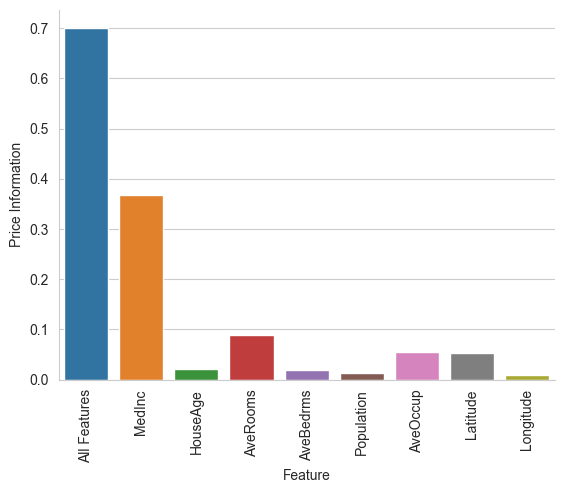

In [7]:
all_mi_estimates.update(one_mi_estimates)

f, ax = plt.subplots(1,1)
sns.barplot(
    pd.DataFrame([{'Feature': name.split(';')[0][2:], 'Price Information': value} for name, value in all_mi_estimates.items()]), 
    x='Feature', y='Price Information',
    ax=ax
)
ax.set_ylim(0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()

By comparing the values of mutual information, we can notice how no single feature alone is as informative as the whole ensamble. However, we can notice that the median income `MedInc` seems to be the most informative feature in the dataset since it contributes about 50% of the total information.

## Determining the least informative feature

We can similarly determine the least informative feature by removing them one by one and estimating the corresponding value of mutual information. If the mutual information value obtained without one feature is similar to the value obtained with all of them, then the removed feature does not add any contribution in predicting the target:
$$
I(x_1,..,x_{j-1},x_j,x_{j+1},..,x_n; y) = I(x_1,..,x_{j-1},x_{j+1},..,x_n; y) \implies I(x_j; y| x_1,..,x_{j-1},x_{j+1},..,x_n ) = 0
$$ 

In [8]:
# We create a dictionary containing all features but one
all_but_one = {
    f"No {feature}": dataframe[[f for f in features if f!=feature]].values.astype(np.float32) for feature in features
}
all_but_one[target] = targets
all_but_one = normalize(all_but_one)
all_but_one.keys()

# Define a SMILE base estimator
base_estimator = smile(
    x_dim=len(features)-1,
    y_dim=1,
    hidden_dims=[256, 128, 64],
    neg_samples=8
)

# Create a copy for each pair of feature and target
estimators = {(f"No {feature}", target): deepcopy(base_estimator) for feature in features}

# Instantiate a MultiMIEstimator to estimate all the values at once
multi_estimator = MultiMIEstimator(
    estimators
)

# Train all the estimator and determine the corresponding values of mutual information
all_but_one_mi_estimates, all_but_one_train_log = estimate_mi(
    estimator=multi_estimator,
    data=all_but_one,
    batch_size=128,
    max_epochs=50,
)

Training the estimator


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration:   0%|          | 0/146 [00:00<?, ?it/s]

Losing patience: 4
Losing patience: 4
Losing patience: 4
Losing patience: 4
Losing patience: 3
Losing patience: 4
Losing patience: 3
Losing patience: 2
Losing patience: 4
Losing patience: 4
Losing patience: 4
Losing patience: 3
Losing patience: 2
Losing patience: 1
Losing patience: 4
Losing patience: 3
Losing patience: 4
Losing patience: 3
Losing patience: 4
Losing patience: 4
Losing patience: 3
Evaluating the value of Mutual Information
[Warning]: using the train_data to estimate the value of mutual information. Please specify test_data.


(0.0, 0.7558428307923495)

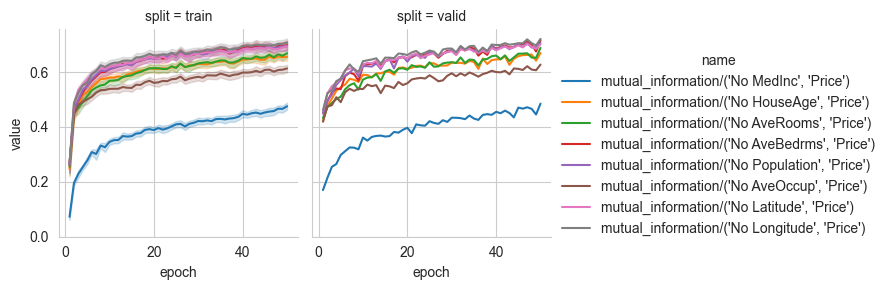

In [9]:
# Visualize the training log
grid = sns.FacetGrid(all_but_one_train_log[all_but_one_train_log['name']!='loss'], col='split', hue='name')
grid.map(sns.lineplot, 'epoch', 'value')
grid.add_legend()
plt.ylim(0)

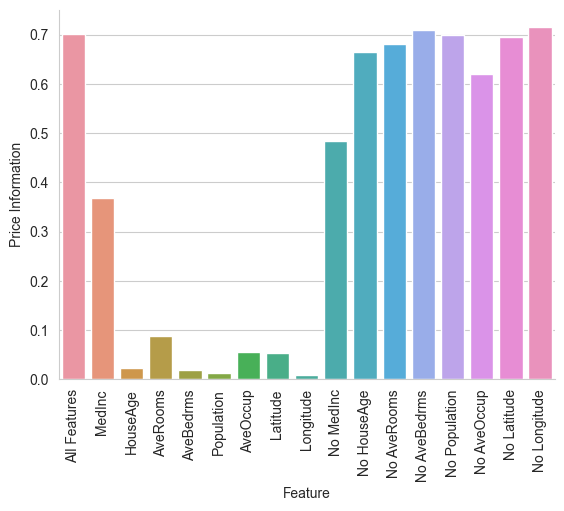

In [10]:
all_mi_estimates.update(all_but_one_mi_estimates)

f, ax = plt.subplots(1,1)
sns.barplot(
    pd.DataFrame([{'Feature': name.split(';')[0][2:], 'Price Information': value} for name, value in all_mi_estimates.items()]), 
    x='Feature', y='Price Information',
    ax=ax
)
ax.set_ylim(0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine()

By considering the mutual information estimates for all-but-one features, we can observe how features such as Longitude, Population and average number of bedrooms give little to no contribution towards predicting the house price.
Note that the mutual information estimates can be noisy because of the random train-validation split and a more accurate evaluation would require multiple seeds and splits. 